## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import librosa
import librosa.display
#from scipy.io import wavfile
import glob
#import wfdb
import time
#from scipy import signal --> Conventional filters: Kalman filter, Chebyshev filter(even degree cosine polynomial basis as in Chebyshev polynomials?)
#, Butterworth filter; separate notebook
#import noisereduce as nr --> separate notebook
#import tsmoothie --> separate notebook
import math
import pywt #Installation: pip install PyWavelets --> For wavelet based reconstructions
from sympy import Symbol, solve, nsolve, log, N, evalf #Installation: pip install sympy
# --> For higher precision lmbda since librosa.load gives 9 decimal digits (float32)
import soundfile as sf

# Data Files

In [2]:
npy_path = '../raw_data/npy_synchronised_unpadded/'
data_path = '../raw_data/'

In [3]:
circor = pd.read_csv(os.path.join(data_path,'training_data.csv'))
circor = circor.drop(columns = ['Pregnancy status', 'Age', 'Sex', 'Height', 'Weight',
       'Pregnancy status',  'Systolic murmur timing',
       'Systolic murmur shape', 'Systolic murmur grading',
       'Systolic murmur pitch', 'Systolic murmur quality',
       'Diastolic murmur timing', 'Diastolic murmur shape',
       'Diastolic murmur grading', 'Diastolic murmur pitch',
       'Diastolic murmur quality', 'Campaign'])

In [4]:
def drop_duplicates(data):
    """ABCD"""
    doublon=data[['Patient ID','Additional ID']].dropna()
    liste_couple=[]
    for i in range(len(doublon)):
        min_id=min(doublon.iloc[i]['Patient ID'],doublon.iloc[i]['Additional ID'])
        max_id=max(doublon.iloc[i]['Patient ID'],doublon.iloc[i]['Additional ID'])
        if [min_id,max_id] not in liste_couple:
            liste_couple.append([min_id,max_id])
    list_id_drop=np.array(liste_couple)[:,1]
    data_drop_dup=data[~data['Patient ID'].isin(list_id_drop)]
    return data_drop_dup

In [5]:
circor_dropped = drop_duplicates(circor)
circor_dropped=circor_dropped[circor_dropped['Recording locations:']=='AV+PV+TV+MV']
circor_dropped=circor_dropped[~(circor_dropped['Murmur']=='Unknown')]
circor_dropped['Outcome'] = circor_dropped['Outcome'].map({'Normal': 0, 'Abnormal':1 })
circor_dropped = circor_dropped.drop(columns='Additional ID')

circor_dropped #Keep the index as such

,Patient ID,Recording locations:,Murmur,Murmur locations,Most audible location,Outcome
0,2530,AV+PV+TV+MV,Absent,NaN,NaN,1
1,9979,AV+PV+TV+MV,Present,AV+MV+PV+TV,TV,1
3,13918,AV+PV+TV+MV,Present,TV,TV,1
4,14241,AV+PV+TV+MV,Present,AV+MV+PV+TV,PV,1
5,14998,AV+PV+TV+MV,Absent,NaN,NaN,1
...,...,...,...,...,...,...
934,85337,AV+PV+TV+MV,Absent,NaN,NaN,0
935,85338,AV+PV+TV+MV,Absent,NaN,NaN,0
937,85340,AV+PV+TV+MV,Absent,NaN,NaN,0
938,85341,AV+PV+TV+MV,Absent,NaN,NaN,0


In [6]:
tmp_df=circor_dropped[~(circor_dropped['Murmur locations'].isnull())]
tmp_df

,Patient ID,Recording locations:,Murmur,Murmur locations,Most audible location,Outcome
1,9979,AV+PV+TV+MV,Present,AV+MV+PV+TV,TV,1
3,13918,AV+PV+TV+MV,Present,TV,TV,1
4,14241,AV+PV+TV+MV,Present,AV+MV+PV+TV,PV,1
8,29045,AV+PV+TV+MV,Present,AV+MV+PV+TV,TV,1
11,33151,AV+PV+TV+MV,Present,MV+TV,TV,1
...,...,...,...,...,...,...
856,85198,AV+PV+TV+MV,Present,AV+MV+PV+TV,AV,1
860,85207,AV+PV+TV+MV,Present,AV+MV+PV+TV,TV,1
867,85219,AV+PV+TV+MV,Present,MV+PV+TV,PV,1
892,85261,AV+PV+TV+MV,Present,AV+MV+PV+TV,TV,1


In [7]:
tmp_df=circor_dropped[~(circor_dropped['Most audible location'].isnull())]
tmp_df

,Patient ID,Recording locations:,Murmur,Murmur locations,Most audible location,Outcome
1,9979,AV+PV+TV+MV,Present,AV+MV+PV+TV,TV,1
3,13918,AV+PV+TV+MV,Present,TV,TV,1
4,14241,AV+PV+TV+MV,Present,AV+MV+PV+TV,PV,1
8,29045,AV+PV+TV+MV,Present,AV+MV+PV+TV,TV,1
11,33151,AV+PV+TV+MV,Present,MV+TV,TV,1
...,...,...,...,...,...,...
856,85198,AV+PV+TV+MV,Present,AV+MV+PV+TV,AV,1
860,85207,AV+PV+TV+MV,Present,AV+MV+PV+TV,TV,1
867,85219,AV+PV+TV+MV,Present,MV+PV+TV,PV,1
892,85261,AV+PV+TV+MV,Present,AV+MV+PV+TV,TV,1


# Multilevel Discrete Wavelet Transforms

**We use a wavelet transform to reconstruct....**

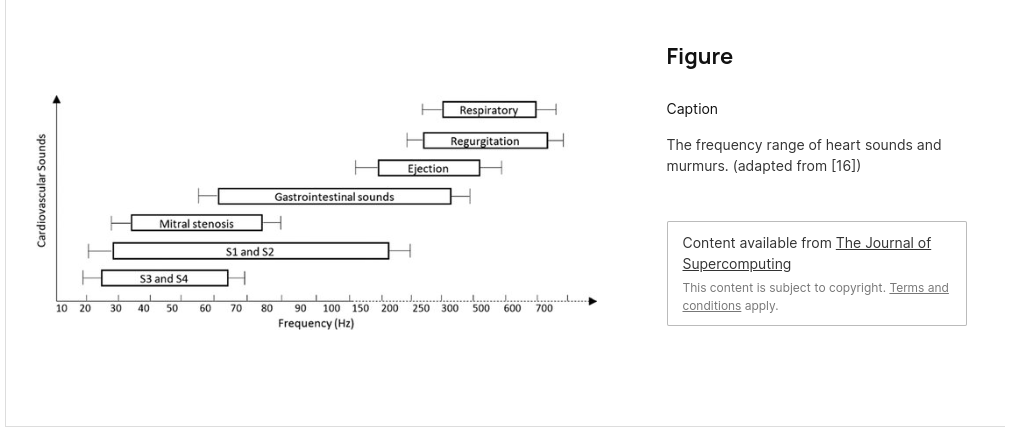

Control over frequency bands with wavelets unclear...

## NeighBlock Method

In the following, we shall need a constant $\lambda$ , that satisfies 
\begin{equation}
\lambda - \log(\lambda) = 3
\end{equation}

In [8]:
z = Symbol('z')
sol_set = solve(z - log(z) - 3, z, dict=True)
sol_set

[{z: -LambertW(-exp(-3))}, {z: -LambertW(-exp(-3), -1)}]

The solutions are in terms of the Lambert $W_k(z)$ function, which is the $k$-th branch solution of the equation:
\begin{equation}
w e^w = z 
\end{equation}
We shall pick the branch: $$z = - W_{-1}\left(-\frac{1}{e^{3}}\right)$$

In [9]:
lmbd = N(sol_set[1][z], 10) #Since librosa gives 9 decimal places
lmbd

4.505241496

In [10]:
type(lmbd)

sympy.core.numbers.Float

In [11]:
lmbd = float(lmbd)

The first solution is:

In [12]:
N(sol_set[0][z], 10)

0.05246909746

which may be excluded due to reasons given in the paper mentioned$\ldots$

**Citation for the github pages; NeighBlock paper; Improvement on the NeighBlock paper...**

The following two blocks are slightly adapted from....

In [13]:
def nb_beta(detail, L, sigma):
    """!!!!ABCD!!!!"""
    S2 = np.sum(detail ** 2)
    beta = (1 - lmbd * L * sigma**2 / S2)
    return max(0, beta)

In [14]:
def neigh_block(details, n, sigma):
    """!!!!ABCD!!!!"""
    res = list()
    L0 = math.floor(np.log2(n) / 2)
    L1 = max(1, math.floor(L0 / 2))
    L = L0 + 2 * L1
    
    for d in details:
        d2 = d.copy()
        for start_b in range(0, len(d2), L0):
            end_b = min(len(d2), start_b + L0)
            start_B = start_b - L1
            end_B = start_B + L
            if start_B < 0:
                end_B -= start_B
                start_B = 0
            elif end_B > len(d2):
                start_B -= end_B - len(d2)
                end_B = len(d2)
            assert end_B - start_B == L
            d2[start_b:end_b] *= nb_beta(d2[start_B:end_B], L, sigma)
        res.append(d2)
    return res

In [15]:
def reconstruct_signal(sig, wavelet = 'db11', level = None, mode = 'antireflect', sigma=0.02):
    """ABCD"""

    coeffs = pywt.wavedec(data=sig,wavelet= wavelet, level = level, mode=mode)
    #Daubechies 11, 14,and 20; Symlet (sym) 9, 11, and 14; Coiflet (???) 4 and 5; subset

    #Default level = max; 5 seems sufficient
    #Default mode = 'symmetric'; antireflect and periodize seem appropriate
    approx = coeffs[0]
    details = coeffs[1:]
    
    details_nb = neigh_block(details, sig.shape[0] , sigma = sigma) #sigma is a noise level; unclear how to choose; Gaussian white noise assumed
    sig_dn = pywt.waverec([approx] + details_nb, wavelet= wavelet)
    return sig_dn

In [16]:
max_level = pywt.dwt_max_level(data_len = 60_000, filter_len = 'db11')
max_level

11

The max level is given by:
\begin{equation}
\textrm{max_level} = \left\lfloor \log_2 \left(\frac{ \textrm{data_len}}{\textrm{filter_len} - 1}\right) \right\rfloor
\end{equation}

In [17]:
max_level = pywt.dwt_max_level(data_len = 60_000, filter_len = 'db14')
max_level

11

In [18]:
max_level = pywt.dwt_max_level(data_len = 60_000, filter_len = 'db20')
max_level

10

In [19]:
max_level = pywt.dwt_max_level(data_len = 60_000, filter_len = 'sym9')
max_level

11

In [20]:
max_level = pywt.dwt_max_level(data_len = 60_000, filter_len = 'sym11')
max_level

11

In [21]:
max_level = pywt.dwt_max_level(data_len = 60_000, filter_len = 'sym14')
max_level

11

In [22]:
max_level = pywt.dwt_max_level(data_len = 60_000, filter_len = 'coif4')
max_level

11

In [23]:
max_level = pywt.dwt_max_level(data_len = 60_000, filter_len = 'coif5')
max_level

11

In [24]:
wavelet_list = pywt.wavelist()
wavelet_list

['bior1.1',
 'bior1.3',
 'bior1.5',
 'bior2.2',
 'bior2.4',
 'bior2.6',
 'bior2.8',
 'bior3.1',
 'bior3.3',
 'bior3.5',
 'bior3.7',
 'bior3.9',
 'bior4.4',
 'bior5.5',
 'bior6.8',
 'cgau1',
 'cgau2',
 'cgau3',
 'cgau4',
 'cgau5',
 'cgau6',
 'cgau7',
 'cgau8',
 'cmor',
 'coif1',
 'coif2',
 'coif3',
 'coif4',
 'coif5',
 'coif6',
 'coif7',
 'coif8',
 'coif9',
 'coif10',
 'coif11',
 'coif12',
 'coif13',
 'coif14',
 'coif15',
 'coif16',
 'coif17',
 'db1',
 'db2',
 'db3',
 'db4',
 'db5',
 'db6',
 'db7',
 'db8',
 'db9',
 'db10',
 'db11',
 'db12',
 'db13',
 'db14',
 'db15',
 'db16',
 'db17',
 'db18',
 'db19',
 'db20',
 'db21',
 'db22',
 'db23',
 'db24',
 'db25',
 'db26',
 'db27',
 'db28',
 'db29',
 'db30',
 'db31',
 'db32',
 'db33',
 'db34',
 'db35',
 'db36',
 'db37',
 'db38',
 'dmey',
 'fbsp',
 'gaus1',
 'gaus2',
 'gaus3',
 'gaus4',
 'gaus5',
 'gaus6',
 'gaus7',
 'gaus8',
 'haar',
 'mexh',
 'morl',
 'rbio1.1',
 'rbio1.3',
 'rbio1.5',
 'rbio2.2',
 'rbio2.4',
 'rbio2.6',
 'rbio2.8',
 'rbio3.1',

In [25]:
len(wavelet_list)

127

In [26]:
mode_list = pywt.Modes.modes
mode_list

['zero',
 'constant',
 'symmetric',
 'periodic',
 'smooth',
 'periodization',
 'reflect',
 'antisymmetric',
 'antireflect']

In [27]:
# for patient_id in circor_dropped['Patient ID']:
#     file_path = os.path.join(f'../raw_data/npy_synchronised_unpadded/{patient_id}{*}.npy')
#     print(file_path)

def save_treated_npy_wav_files(wavelet = 'db11', level = None, mode = 'antireflect', sigma=0.02):
    """ABCD"""
    for file_path in glob.glob(os.path.join(npy_path,f'*.npy')):
        for patient_id in circor_dropped['Patient ID']:
            if str(patient_id) in file_path:
                sig = np.load(file_path)
                sig_dn = reconstruct_signal(sig, wavelet = wavelet, level = level, mode = mode, sigma=sigma)
                tmp_file_path_npy = file_path.replace('npy_synchronised_unpadded', 'npy_synchronised_unpadded_treated')
                tmp_file_path_wav = file_path.replace('npy_synchronised_unpadded', 'audio_treated').replace('npy','wav')
                np.save(tmp_file_path_npy, sig_dn)
                sf.write(file=tmp_file_path_wav, data=sig_dn, samplerate=4000, subtype='PCM_24')
    return

**SAVING FILES**

In [61]:
# %%time
# #UNCOMMENT TO SAVE FILES
# save_treated_npy_wav_files(wavelet = 'db14', level = 8, mode = 'antireflect', sigma=0.015)

CPU times: user 4min 37s, sys: 2.78 s, total: 4min 40s
Wall time: 5min 10s


In [29]:
#Deleted

## NeighCoeff method [a variation of NeighBlock with a different parameter definitions]

**Seems slightly less helpful than NeighBlock -- may try later, depending on NeighBlock performance**

## (Random) Tests

In [47]:
def sig_generator(patient_id, location):
    """ABCD"""
    sig = np.load(os.path.join(npy_path, f'{str(patient_id)}_{location}.npy'))
    return sig

In [48]:
sig_generator(2530, 'AV')

array([ 0.02145386,  0.02481079,  0.02648926, ..., -0.00769043,
       -0.00531006, -0.00137329], dtype=float32)

In [66]:
tmp_array = np.load(os.path.join(npy_path, '39403_AV.npy'))
tmp_array.shape

(23356,)

In [67]:
tmp_array = np.load(os.path.join('../raw_data/npy_synchronised_unpadded_treated/', '39403_AV.npy'))
tmp_array.shape

(23356,)

In [69]:
tmp_array = np.load(os.path.join(npy_path, '39403_PV.npy'))
tmp_array.shape

(49605,)

In [71]:
tmp_array = np.load(os.path.join('../raw_data/npy_synchronised_unpadded_treated/', '39403_PV.npy'))
tmp_array.shape

(49606,)

**It is expected to lose a few points under reconstruction due to edge effects??**

In [49]:
def plot_reconst_orig(patient_id, location, start = 2000, end = 3000, wavelet='db11', level=None, mode='antireflect', sigma=0.02):
    """ABCD"""
    sig = sig_generator(patient_id, location)

    sig_dn = reconstruct_signal(sig=sig, wavelet = wavelet, level = level, mode = mode, sigma=sigma)
    plt.figure(figsize=(16,4))
    plt.title(f"Reconstructed signal vs Original signal for {patient_id}_{location}.wav, {wavelet}, level ={level}, mode = {mode}, sigma = {sigma}")
    plt.plot(sig[start:end], label = 'signal')
    plt.plot(sig_dn[start:end], label = 'reconstructed signal')
    plt.legend(loc = 'best')
    plt.show()

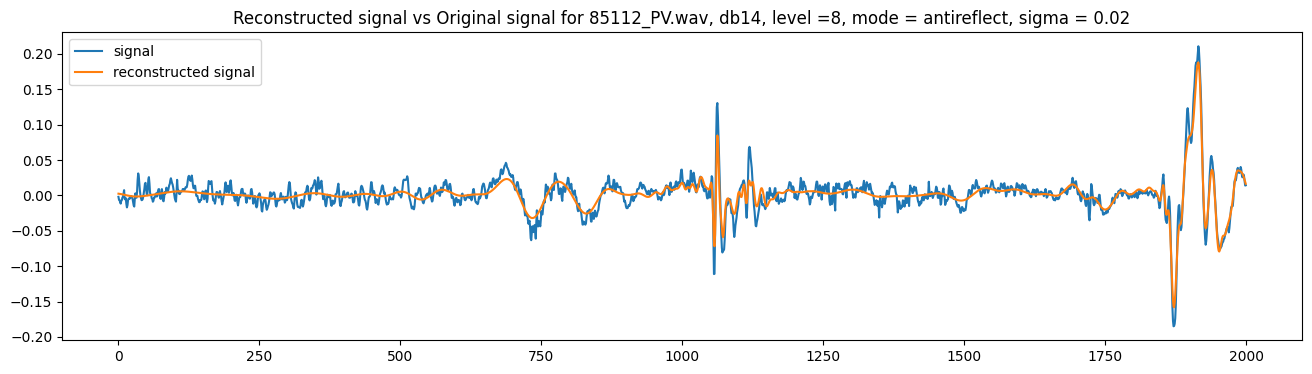

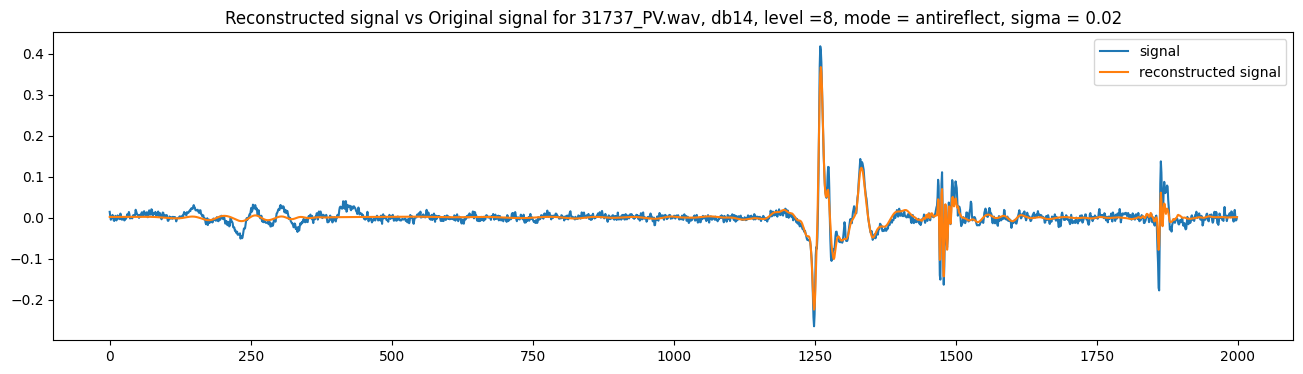

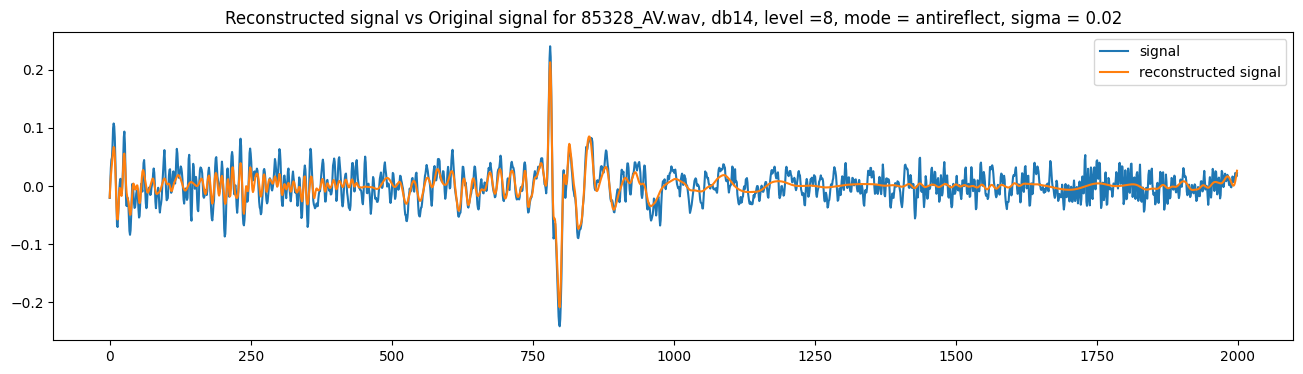

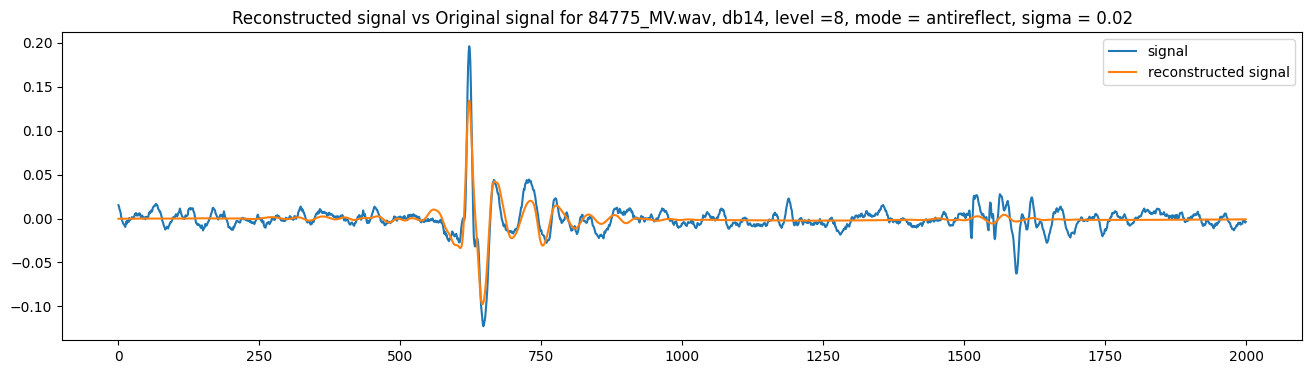

In [50]:
for j in range(4):
 #   np.random.seed(16)
    pid = circor_dropped.iloc[np.random.randint(0, circor_dropped.shape[0]), 0]
  #  np.random.seed(64)
    location = np.random.choice(a = ['AV', 'PV', 'TV', 'MV'], size = 1, p = [0.2, 0.2, 0.3, 0.3] )[0]

    plot_reconst_orig(pid, location, start=2000, end=4000, wavelet='db14', level = 8, mode='antireflect', sigma=0.02)

In [51]:
mode_list

['zero',
 'constant',
 'symmetric',
 'periodic',
 'smooth',
 'periodization',
 'reflect',
 'antisymmetric',
 'antireflect']

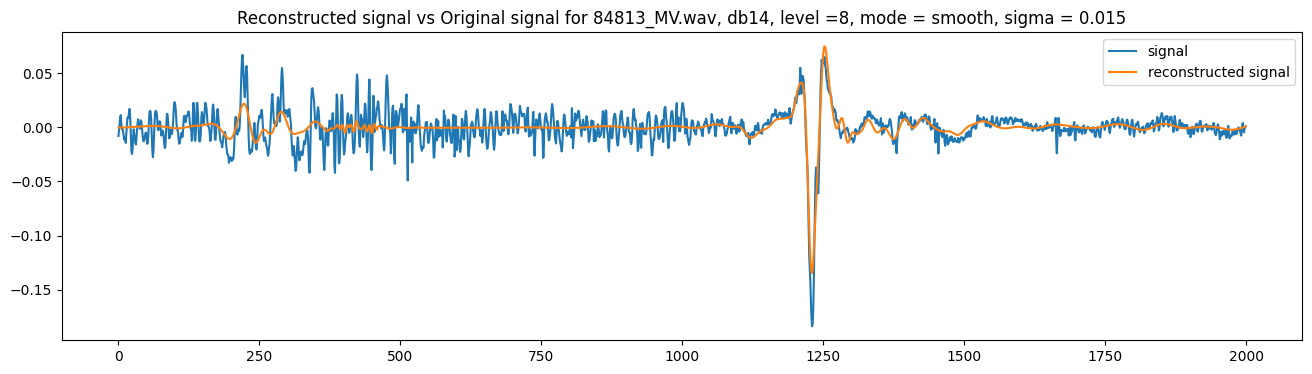

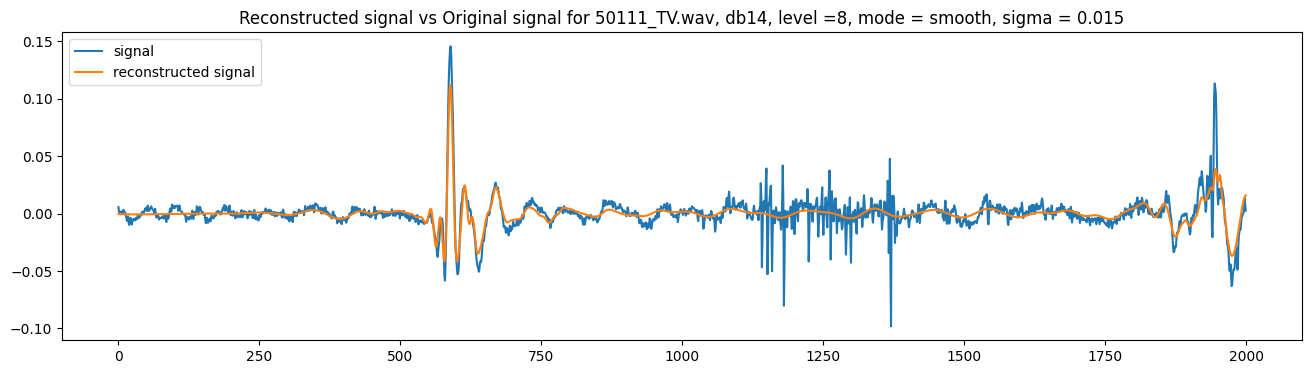

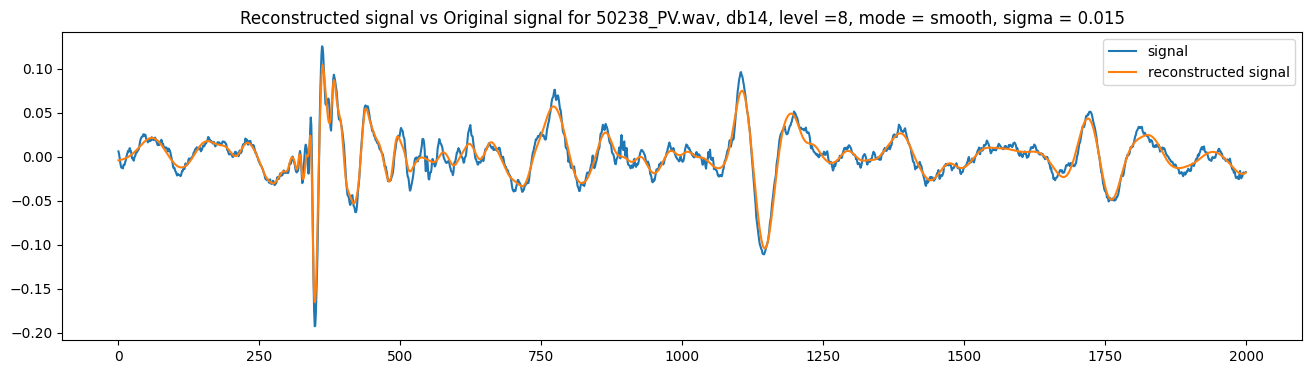

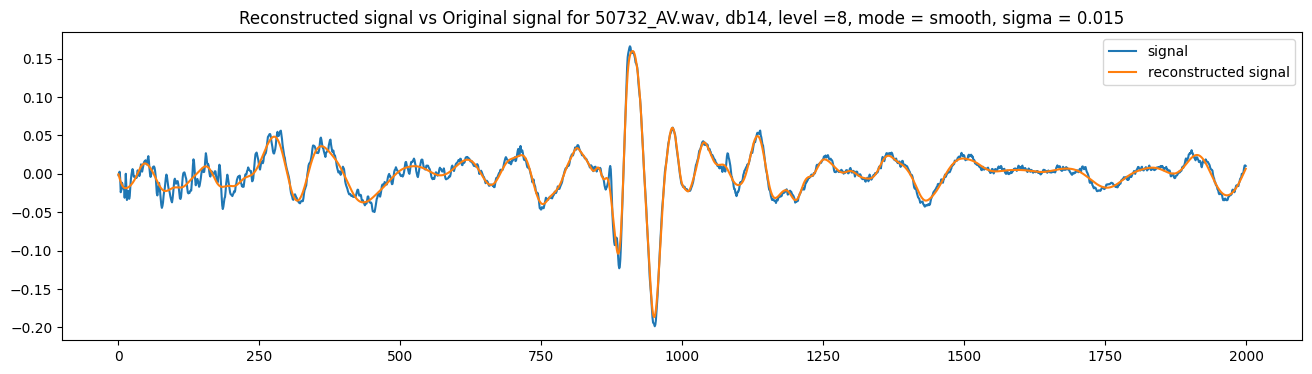

In [52]:
for j in range(4):
 #   np.random.seed(16)
    pid = circor_dropped.iloc[np.random.randint(0, circor_dropped.shape[0]), 0]
  #  np.random.seed(64)
    location = np.random.choice(a = ['AV', 'PV', 'TV', 'MV'], size = 1, p = [0.2, 0.2, 0.3, 0.3] )[0]

    plot_reconst_orig(pid, location, start=2000, end=4000, wavelet='db14', level = 8, mode='smooth', sigma=0.015)

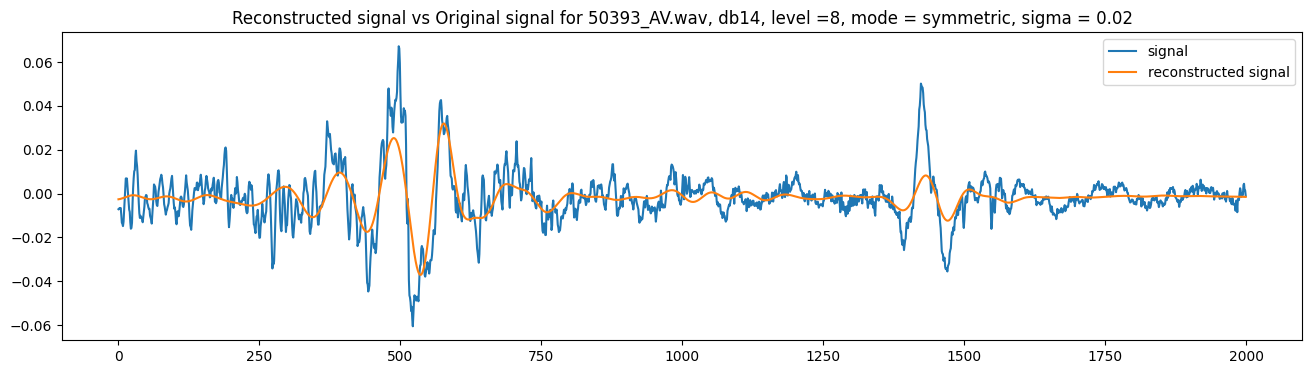

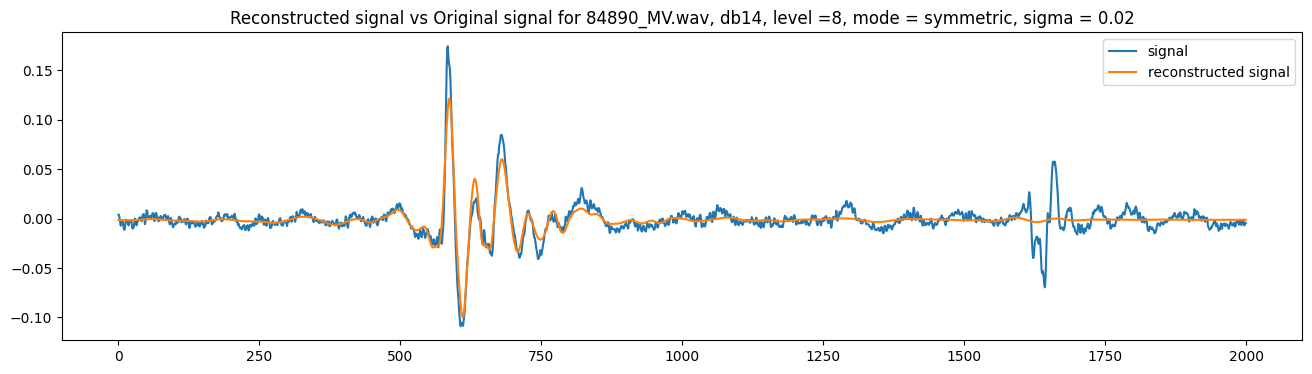

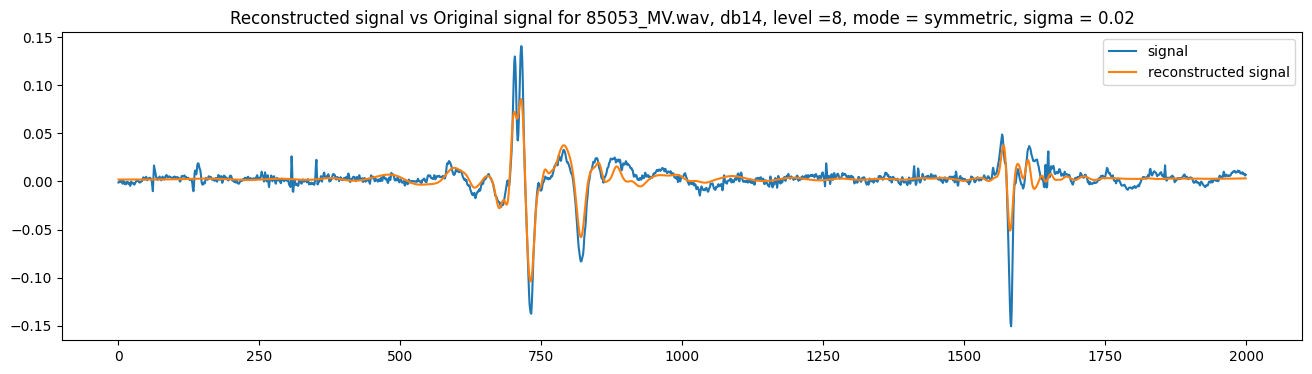

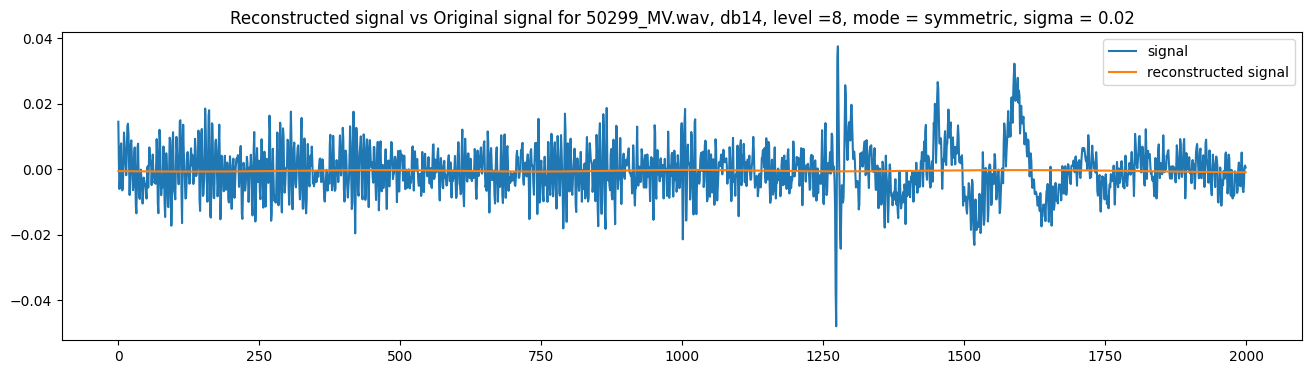

In [53]:
for j in range(4):
 #   np.random.seed(16)
    pid = circor_dropped.iloc[np.random.randint(0, circor_dropped.shape[0]), 0]
  #  np.random.seed(64)
    location = np.random.choice(a = ['AV', 'PV', 'TV', 'MV'], size = 1, p = [0.2, 0.2, 0.3, 0.3] )[0]

    plot_reconst_orig(pid, location, start=2000, end=4000, wavelet='db14', level = 8, mode='symmetric', sigma=0.02)

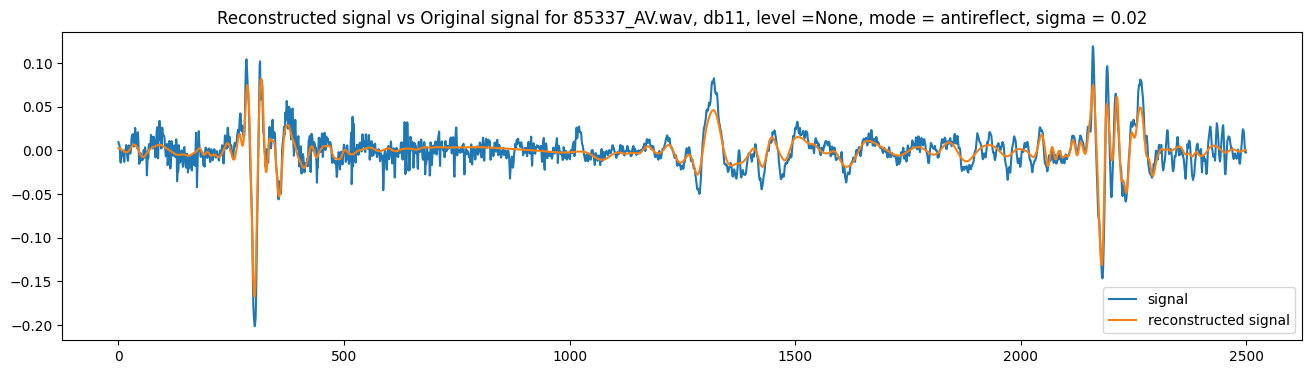

In [54]:
#plot_reconst_orig(85337, 'AV', 1500, 4000)

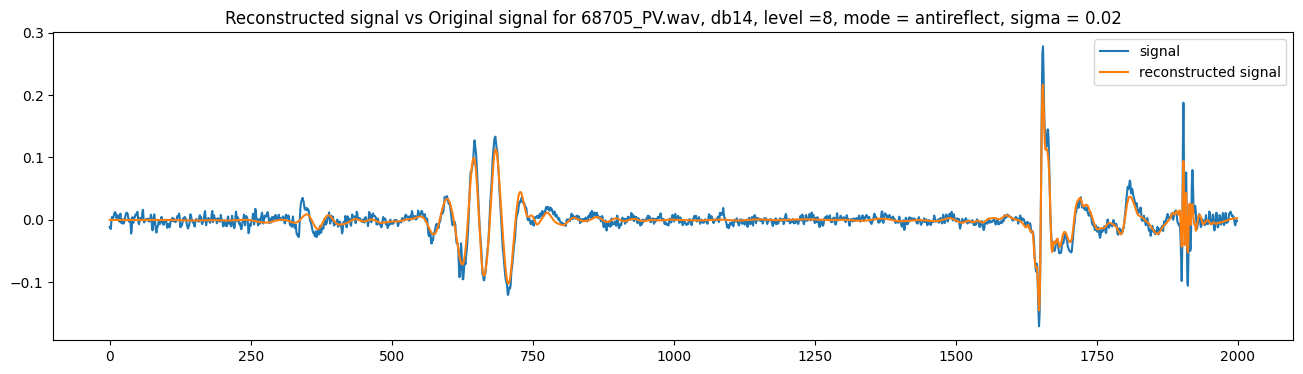

In [55]:
for j in range(1):
    np.random.seed(16)
    pid = circor_dropped.iloc[np.random.randint(0, circor_dropped.shape[0]), 0]
    np.random.seed(64)
    location = np.random.choice(a = ['AV', 'PV', 'TV', 'MV'], size = 1, p = [0.2, 0.2, 0.3, 0.3] )[0]

    plot_reconst_orig(pid, location, start=2000, end=4000, wavelet='db14', level = 8, mode='antireflect', sigma=0.02)

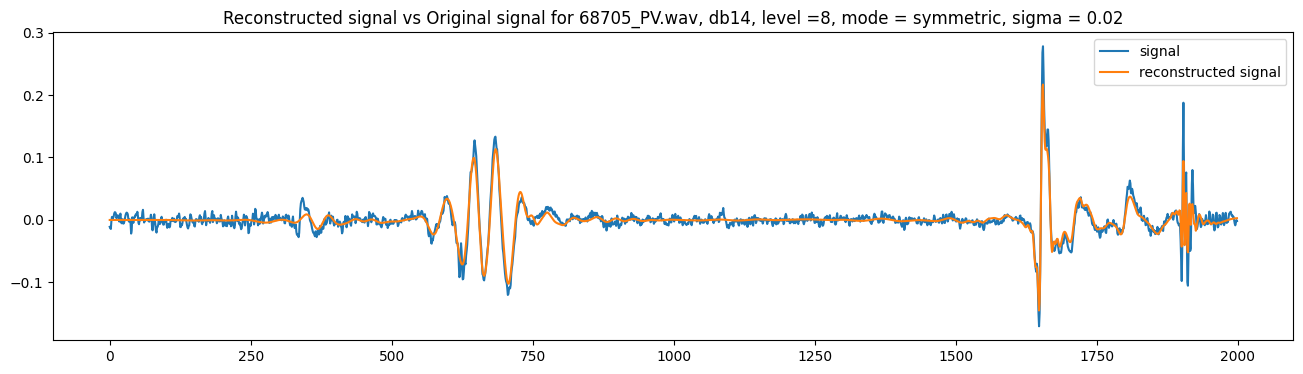

In [56]:
for j in range(1):
    np.random.seed(16)
    pid = circor_dropped.iloc[np.random.randint(0, circor_dropped.shape[0]), 0]
    np.random.seed(64)
    location = np.random.choice(a = ['AV', 'PV', 'TV', 'MV'], size = 1, p = [0.2, 0.2, 0.3, 0.3] )[0]

    plot_reconst_orig(pid, location, start=2000, end=4000, wavelet='db14', level = 8, mode='symmetric', sigma=0.02)

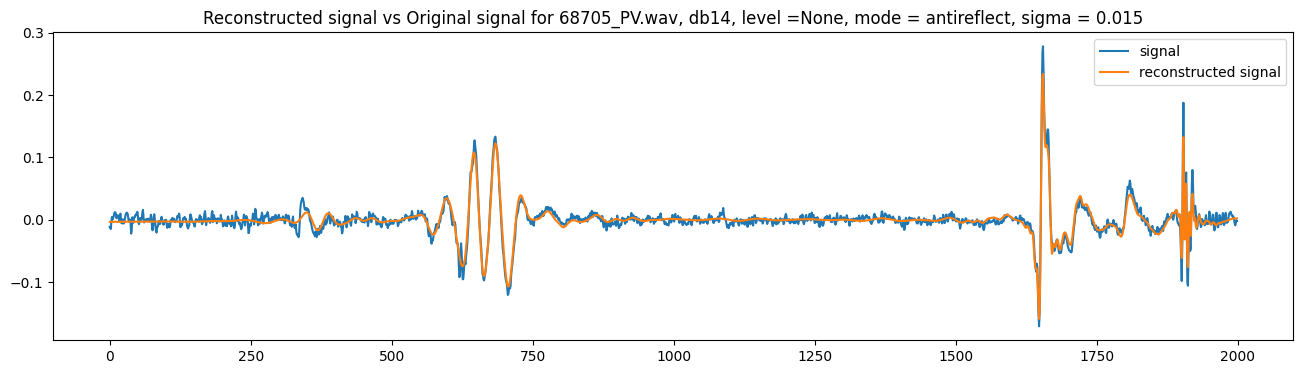

In [57]:
for j in range(1):
    np.random.seed(16)
    pid = circor_dropped.iloc[np.random.randint(0, circor_dropped.shape[0]), 0]
    np.random.seed(64)
    location = np.random.choice(a = ['AV', 'PV', 'TV', 'MV'], size = 1, p = [0.2, 0.2, 0.3, 0.3] )[0]

    plot_reconst_orig(pid, location, start=2000, end=4000, wavelet='db14', level = None, mode='antireflect', sigma=0.015)

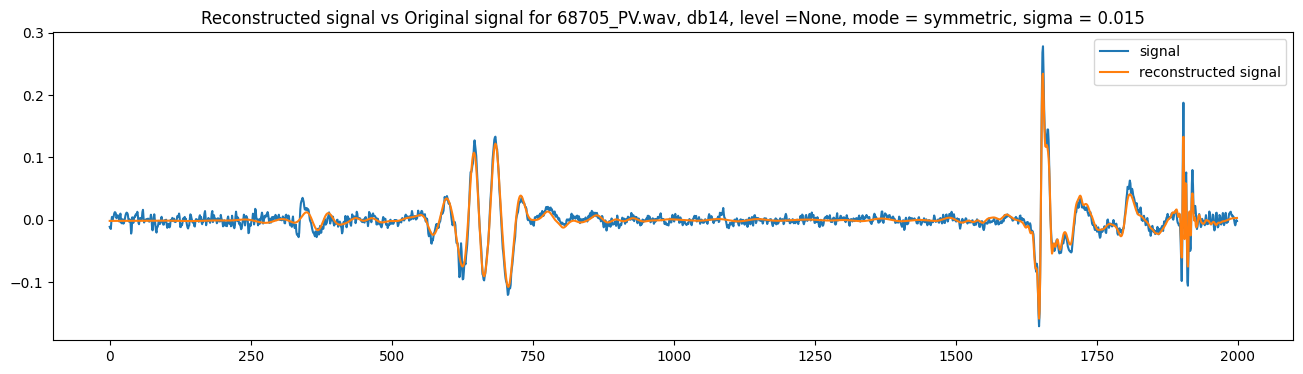

In [58]:
for j in range(1):
    np.random.seed(16)
    pid = circor_dropped.iloc[np.random.randint(0, circor_dropped.shape[0]), 0]
    np.random.seed(64)
    location = np.random.choice(a = ['AV', 'PV', 'TV', 'MV'], size = 1, p = [0.2, 0.2, 0.3, 0.3] )[0]

    plot_reconst_orig(pid, location, start=2000, end=4000, wavelet='db14', level = None, mode='symmetric', sigma=0.015)

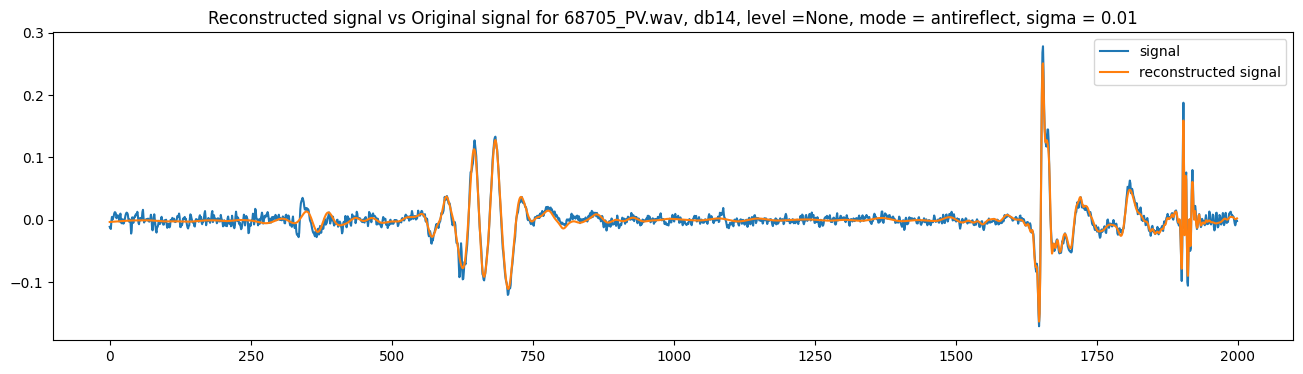

In [59]:
for j in range(1):
    np.random.seed(16)
    pid = circor_dropped.iloc[np.random.randint(0, circor_dropped.shape[0]), 0]
    np.random.seed(64)
    location = np.random.choice(a = ['AV', 'PV', 'TV', 'MV'], size = 1, p = [0.2, 0.2, 0.3, 0.3] )[0]

    plot_reconst_orig(pid, location, start=2000, end=4000, wavelet='db14', level = None, mode='antireflect', sigma=0.01)

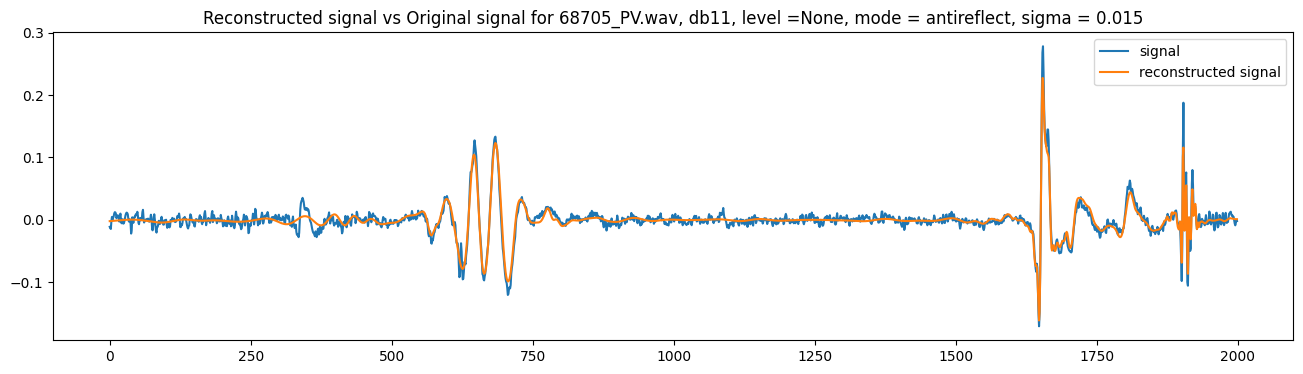

In [60]:
for j in range(1):
    np.random.seed(16)
    pid = circor_dropped.iloc[np.random.randint(0, circor_dropped.shape[0]), 0]
    np.random.seed(64)
    location = np.random.choice(a = ['AV', 'PV', 'TV', 'MV'], size = 1, p = [0.2, 0.2, 0.3, 0.3] )[0]

    plot_reconst_orig(pid, location, start=2000, end=4000, wavelet='db11', level = None, mode='antireflect', sigma=0.015)

# Cycle average [Uncertain about effect on the murmur component of the signal]

# Measures of Noise

## SNR

In [63]:
def snr(sig, axis=0, ddof=0):
    """ABCD"""
    mean_of_sq = np.mean(sig**2)
    sd = np.std(sig)    #the default ddof in numpy is 0 as for population std
    snr = float(np.where(sd == 0, 0, mean_of_sq/sd**2))
    return snr

In [64]:
snr(sig)

1.000072935082535

In [65]:
snr(sig_recons)

1.0000728932757459

In [79]:
np.array(reduced_noise)

numpy.memmap

In [78]:
reduced_noise[:1200].shape

(1200,)

In [65]:
sig[:1200].shape

(1200,)

***Does not seem to be helpful to measure noise in our signals...***

## RSNR [cannot define it purely in terms of the signal yet]

## Hilbert transform for instantaneous frequency test

Defn:
\begin{equation}
{\displaystyle \operatorname {H} (u)(t)={\frac {1}{\pi }}\,\operatorname {p.v.} \int _{-\infty }^{+\infty }{\frac {u(\tau )}{t-\tau }}\;\mathrm {d} \tau ,}
\end{equation}

\begin{equation}
H(f)(x)=-i{\bigl (}F_{+}(x)+F_{-}(x){\bigr )}\, .
\end{equation}

\begin{equation}
{\displaystyle {\frac {1}{\,2\,}}\cot \left({\frac {x}{2}}\right)={\frac {1}{x}}+\sum _{n=1}^{\infty }\left({\frac {1}{x+2n\pi }}+{\frac {1}{\,x-2n\pi \,}}\right)}
\end{equation}

Bedrosian's theorem
\begin{equation}
 \operatorname {H} \left(f_{\text{LP}}(t)\cdot f_{\text{HP}}(t)\right)=f_{\text{LP}}(t)\cdot \operatorname {H} \left(f_{\text{HP}}(t)\right),
\end{equation}

Instantaneous phase and frequency;

Angle modulation
\begin{equation}
{\displaystyle u(t)=A\cdot \cos(\omega t+\phi _{m}(t))}
\end{equation}

## Standard deviation for the time period for the $1 \rightarrow 4$ cycle from the tsv file [For phase noise, librosa.angle]